# Example: Long short-term memory network (LSTM)


Process outline
1. Prepare time delay features
2. Spatial aggregation
   - Area weighted sum for precipitation features
   - Area mean for all other features
3. Define the model
4. Train the model
   - Reshape the input dataset to the model specific `X` and `y` arrays
   - Actually train on `X` and `y`

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dask
dask.config.set(scheduler='threads')
import xarray as xr

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [2]:
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')

Its datatype is `xarray.Dataset`, containing a spatio-temporal subset of 5 variables that we selected from the original ERA5 dataset. It also contains one derived variable (`rtp_500-850`) that is used in Meteorology quite a bit because it is proportional to mass-weighted mean temperature of the air, in this case between 850 and 500 hPa. It could be an additional predictor to classify the weather regime.

In [3]:
era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

To access a variable's description, select one like this:

In [4]:
era5['cp']

<xarray.DataArray 'cp' (time: 5478, latitude: 13, longitude: 25)>
[1780350 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude  (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Attributes:
    standard_name:  lwe_thickness_of_convective_precipitation_amount
    long_name:      Convective precipitation
    units:          m

### Selecting useful predictor variables
The selection has already been done by us when preparing the small sample datasets for you, so you can use them straight away. What is still necessary, is clustering and reshaping the input data dimension, because the dimensionality of the raw input data would be too high: 

To give a rough estimate, imagine using all GloFAS and ERA5 gridpoints of the upstream area of one point. For 1.5x1.5  degree (lat,lon), ERA5 provides 6 x 6 and GloFAS 15 x 15 gridpoints. To take the time dimension into account we'd need, say, 10 days of discharge and 180 days of precipitation. 

Summing up, this makes the raw input dimensionality 15 x 15 x 10 and 6 x 6 x 180, in total ~8700 features, where most of the predictors won't vary that much from one gridpoint to another in the upstream area (large scale temperature, total-column water vapor).

To work around that, we need to 
  1. spatially aggregate  and 
  2. temporally aggregate the data (reduce dimensionality). 
  
Both will be done in sections below, but first we need to define which point we will be making forecasts for.

### Selecting the predictand
The target variable shall be the discharge at the point where the Danube river leaves the data domain. This is given by the point within the catchment where the discharge is the highest, so we first filter by the catchment basin shapefile (Worldbank dataset "Global River Basins")

To select the basin from the shapefile, we use a function defined in `./aux/utils.py`. The interested user may have a look there how it is done, but it would obstruct the clarity in this notebook. To import the function it needs to be present in the current processes path. We do that by adding the parent/main directory to `sys.path`. In this way we can import some function in `./aux/utils_flowmodel.py` by `from aux.utils_flowmodel import somefunction`.

In [5]:
import sys
sys.path.append("../../")
from python.aux.utils_floodmodel import get_mask_of_basin

In [6]:
danube_catchment = get_mask_of_basin(glofas['dis'].isel(time=0))
dis = glofas['dis'].where(danube_catchment)
dis_mean = dis.mean('time')

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Now we look up the coordinates of the maximum discharge point. We see that the point of interest is at 48.35 degree latitude and 13.95 degree longitude.

In [7]:
maximum = dis.where(dis==dis.max(), drop=True)
lat, lon = float(maximum.latitude), float(maximum.longitude)
maximum

<xarray.DataArray 'dis' (time: 1, latitude: 1, longitude: 1)>
array([[[4148.968]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 13.95
  * latitude   (latitude) float64 48.35
  * time       (time) datetime64[ns] 1981-07-22
Attributes:
    long_name:  discharge
    units:      m3/s

To double-check, plot a circle around the point of interest. Indeed, its the point we looked for.

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


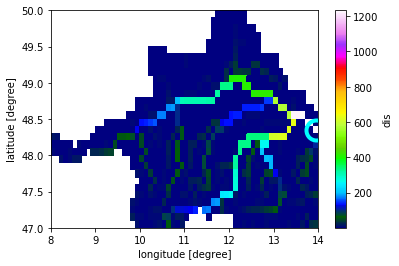

In [8]:
dis.mean('time').plot(cmap='gist_ncar')
plt.gca().plot(lon, lat, color='cyan', marker='o', 
                     markersize=20, mew=4, markerfacecolor='none')

## 1. Time aggregated predictors
Delayed effect

=> delayed impact, time-shifted precipitation variables

The goal shall be to aggregate over an increasing number of days as we iterate back in time.
What is shifting?

Initial setup `X`:

In [109]:
X = era5[['lsp']]

In [110]:
from python.aux.utils_floodmodel import shift_and_aggregate

## 2. Spatially aggregated predictors
We can either take the total sum of precipitation that falls throughout the basin, or we can aggregate it by time to the point of interest (POI). As we can see from the discharge plot above, points with less mean discharge are further away from the POI compared to gridpoints with a lighter color. This is the motivation to cluster the precipitation points by the mean discharge of the gridpoint. So we need discharge bins, according to which the precipitation at these gridpoints is grouped together to form one feature/predictor. 

For an equal number of points per bin, we can have a look on the percentiles of the discharge distribution. As a first guess let's take four clusters so that the percentiles 0.25, 0.5 and 0.75 are our threshold values between the four clusters: 

In [111]:
for q in [0.25, .5, .75]:
    print('percentile', q, ': ', round(float(dis_mean.quantile(q)),3), 'm^3/s')

percentile 0.25 :  1.028 m^3/s
percentile 0.5 :  2.902 m^3/s
percentile 0.75 :  12.308 m^3/s


Points with less than 0.8 $m^3/s$ discharge are the first cluster, points with 0.8-2.5 $m^3/s$ another cluster and so on. Finally we can add a visual to this, the cumulative distribution of discharges.

We see that 80 percent of all gridpoints exhibit a mean discharge of less than 20 m^3/s, and that there is a sharp change in slope between 5 and 10 m^3/s discharge.

### Create the clusters-masks

In [112]:
from python.aux.utils_floodmodel import cluster_by_discharge

bin_edges = [0, 0.8, 2.5, 10.25, 10000]
cluster = cluster_by_discharge(dis_mean, bin_edges)

To create an image with all clusters in one image, 
we will create a label-array containing a number between 0 and 3 for every gridpoint 
that classifies each gridpoint belonging to one of the four categories. 

In numpy you would probably use the numpy boolean masking operation:
```
for i in range(len(clusters)):
    image[clustering[c]] = i  ```
but you would notice an `IndexError`, as xarray does not support 2-dimensional boolean indexing. So we have to formulate it this way: `image = image.where(~clustering[c], i)`, where not 'this cluster', do nothing, else overwrite with the cluster index

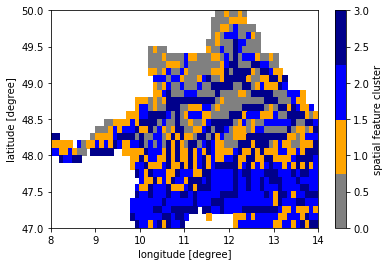

In [113]:
image = dis_mean*0.
image.name = 'spatial feature cluster'
for i, c in enumerate(cluster):
    image = image.where(~cluster[c], i)
    
image.plot(cmap = mpl.colors.ListedColormap(['grey', 'orange', 'blue', 'darkblue']))

These are the gridpoints that are aggregated together to form one precipitation feature for the forecast model. For precipitation that is older than a few days, only the first cluster is of interest. Precipitation that occured on the other gridpoints is already transported outside of the domain for sure.


In [114]:
cluster = cluster.to_array('clusterId')
cluster.coords 

Coordinates:
  * longitude  (longitude) float64 8.05 8.15 8.25 8.35 ... 13.75 13.85 13.95
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * clusterId  (clusterId) <U1 '0' '1' '2' '3'

In [115]:
from python.aux.utils_floodmodel import aggregate_clustersum

Note: as it seems that the spatial clustering does not add any value, we will omit it for the time and work with the spatial mean within the catchment for all variables.

In [138]:
if True:  # alternative: aggregating over space by taking the mean
    Xagg = X.mean(['latitude', 'longitude'])
Xagg

<xarray.Dataset>
Dimensions:  (time: 5478)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
Data variables:
    lsp      (time) float32 0.0030980932 0.0107246665 ... 0.0010424339

In [139]:
y = glofas['dis'].interp(latitude=lat, longitude=lon)
y

<xarray.DataArray 'dis' (time: 5478)>
array([798.361572, 792.207703, 796.706116, ..., 783.30896 , 782.144958,
       778.828003])
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude   float64 48.35
    longitude  float64 13.95
Attributes:
    long_name:  discharge
    units:      m3/s

In [140]:
from python.aux.utils_floodmodel import reshape_multiday_predictand

In [141]:
Xda = Xagg.to_array().T
yda = y

In [143]:
Xda.shape, yda.shape

((5478, 1), (5478,))

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [144]:
period_train = dict(time=slice(None, '1990'))
period_valid = dict(time=slice('1991', '1993'))
period_test = dict(time=slice('1994', '1995'))

In [145]:
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [208]:
from sklearn_xarray import wrap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers.core import Dropout
from keras.constraints import MinMaxNorm, nonneg


def reshape_LSTM(X, y=None, X_time_steps=30, X_features=1, N_times_predict=14):
    """Reshape for LSTM
    
    np.array input and output
    
    TODO: N_times_predict not equal X_time_steps
    """
    samples = int(X.size/(X_time_steps*X_features))
    
    X = X[:samples*X_time_steps*X_features]
    try:
        y = y[:samples*X_time_steps]
    except:
        pass
    
    X = X.reshape(samples, X_time_steps, X_features)
    try:
        y = y.reshape(-1, X_time_steps)
        return X, y
    except:
        return X

    
def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


def add_time_to_sequence_output(array, time, name=None):
    """Add time coordinates to multiday model predictions.

    Parameters
    ----------
    array : numpy.array
        the prediction, 2-dimensional ('init_time', 'fxh')
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    init_time = pd.to_datetime(time.values) - dt.timedelta(hours=1)
    forecast_day = range(1, array.shape[1]+1)
    return xr.DataArray(array, dims=('init_time', 'forecast_day'),
                        coords=dict(init_time=('init_time', init_time),
                                    forecast_day=('forecast_day', forecast_day),
                                    name=name))


class FloodLSTM(object):
    def __init__(self, **kwargs):
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        model = keras.models.Sequential()
        self.cfg = kwargs
        
        nt_predict = self.cfg.get('output_dim', 14)
        X_time_steps = self.cfg.get('X_time_steps', 30)
        X_features = self.cfg.get('X_features', 1)
        model.add(keras.layers.LSTM(nt_predict, 
                                    activation='tanh', 
                                    input_shape=(X_time_steps, X_features)))

        #opt = keras.optimizers.Adadelta(lr=1, rho=0.95, epsilon=0.5, decay=0.0)
        #opt = keras.optimizers.RMSprop()
        #opt = keras.optimizers.SGD()
        opt = keras.optimizers.Adam(lr=0.001, epsilon=0.05, amsgrad=False)

        model.compile(loss=self.cfg.get('loss'), optimizer=opt)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]

    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray"""
        time = Xda.time

        Xda = self.xscaler.transform(Xda)
        X = reshape_LSTM(Xda, X_time_steps=self.cfg['X_time_steps'], 
                                    X_features=self.cfg['X_features'])

        y = self.model.predict(X).squeeze()
        y = self.yscaler.inverse_transform(y)
        print(y.shape)
        if len(y.shape) == 1:
            return add_time(y, time, name=name)
        else: 
            return add_time_to_sequence_output(y, time, name=name)

    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """Inputs: xr.DataArray"""
        
        X_train = self.xscaler.fit_transform(X_train.values)
        X_valid = self.xscaler.transform(X_valid.values)
        
        y_train = self.yscaler.fit_transform(y_train.values.reshape(-1, 1))
        y_valid = self.yscaler.transform(y_valid.values.reshape(-1, 1))
        
        X_train, y_train = reshape_LSTM(X_train, y_train, 
                                        self.cfg['X_time_steps'], 
                                        self.cfg['X_features'])
        
        X_valid, y_valid = reshape_LSTM(X_valid, y_valid, 
                                        self.cfg['X_time_steps'], 
                                        self.cfg['X_features'])
        
        print(X_train.shape, y_train.shape)
        #                y_train.reshape(-1, self.cfg.get('output_dim', 1))
        
        #                y_valid.reshape(-1, self.cfg.get('output_dim', 1))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.cfg.get('epochs', 1000),
                              batch_size=self.cfg.get('batch_size'),
                              callbacks=self.callbacks,
                              verbose=0, **kwargs)

In [209]:
m = FloodLSTM(hidden_nodes=(64,32,16,8,),  #  (32,16,8,4,),  # 
            dropout=0.1,
            X_time_steps=30,  # has to equal X_train.shape[1]
            X_features=1,  # has to equal X_train.shape[2]
            output_dim=30,
            epochs=1000,
            batch_size=180,
            loss='mse')

In [210]:
hist = m.fit(X_train, y_train, X_valid, y_valid)

(121, 30, 1) (121, 30)


In [211]:
m.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 30)                3840      
Total params: 3,840
Trainable params: 3,840
Non-trainable params: 0
_________________________________________________________________


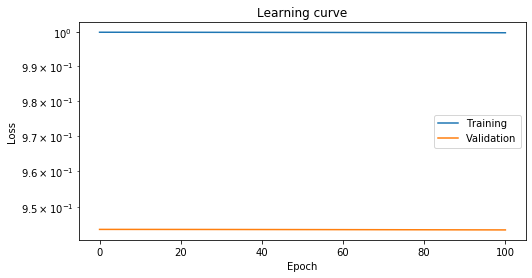

In [212]:
h = hist.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

In [213]:
import os, yaml
dir_model = '../../models/lstm-catchment_mean/'
os.makedirs(dir_model, exist_ok=True)

In [215]:
out = m.predict(X_valid)
out.to_netcdf(dir_model+'validation.nc')

out = m.predict(X_test)
out.to_netcdf(dir_model+'test.nc')

yaml_string = m.model.to_yaml()
with open(dir_model+'config.yml', 'w') as f:
    yaml.dump(yaml_string, f)
    
from contextlib import redirect_stdout
with open(dir_model+'summary.txt', "w") as f:
    with redirect_stdout(f):
        m.model.summary()

(36, 30)


ValueError: conflicting sizes for dimension 'init_time': length 36 on the data but length 1096 on coordinate 'init_time'

In [ ]:
def plot_recurrent(ax, truth, prediction):
    truth.plot(label='truth', linewidth=2)
    for i, init in enumerate(prediction.init_time):
        if not i%7==0: 
            continue
        df = prediction.sel(init_time=init).to_pandas()
        df.index = [pd.Timestamp(init.values) + dt.timedelta(days=i) for i in df.index]
        df.plot(ax=ax)
    ax.legend(['truth'])

In [ ]:
true_dis = glofas['dis'].interp(latitude=lat, longitude=lon)

In [ ]:
fix, ax = plt.subplots(figsize=(15,5))

true_dis.sel(period_test).plot(label='truth')
for d in out.forecast_day:
    out.sel(forecast_day=d).plot(marker='.', label='+'+str(int(d)))
ax.legend()

In [ ]:
fix, ax = plt.subplots(figsize=(15,5))
time='1994-05'


true_dis.sel(time=time).plot(ax=ax, label='truth')
pred = out.sel(init_time=time)

for init in pred.init_time:
    df = out.sel(init_time=init).to_pandas()
    df.index = [pd.Timestamp(init.values) + dt.timedelta(days=i) for i in df.index]
    df.plot(ax=ax, marker='.') #label=str(init))
ax.legend(['truth'])

## 2nd example

In [ ]:
m = DenseNN(hidden_nodes=(12,8,6,4,),  
            dropout=0.0,
            output_dim=14,
            epochs=1000,
            batch_size=180,
            loss='mse')

hist = m.fit(X_train, y_train, X_valid, y_valid)

In [ ]:
m.model.summary()

h = hist.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

import os, yaml
dir_model = '../../models/tdnn-catchment_mean_simple/'
os.makedirs(dir_model, exist_ok=True)

out = m.predict(X_valid)
out.to_netcdf(dir_model+'validation.nc')

out = m.predict(X_test)
out.to_netcdf(dir_model+'test.nc')

yaml_string = m.model.to_yaml()
with open(dir_model+'config.yml', 'w') as f:
    yaml.dump(yaml_string, f)
    
from contextlib import redirect_stdout
with open(dir_model+'summary.txt', "w") as f:
    with redirect_stdout(f):
        m.model.summary()

In [ ]:
true_dis = glofas['dis'].interp(latitude=lat, longitude=lon)

test_time = slice('1994', '1995')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=true_dis.sel(time=test_time), 
                   prediction=out.sel(init_time=test_time))



time=slice('1994-03', '1994-05')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=true_dis.sel(time=time), 
                   prediction=out.sel(init_time=time))
